In [1]:
from google.colab import files
uploaded = files.upload()


Saving archive (11).zip to archive (11) (2).zip


In [2]:
import zipfile
import os

zip_name = 'archive (11).zip'

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall('cardio_data')

print("Extraction complete!")


Extraction complete!


In [3]:
# Basic utilities
import numpy as np
import pandas as pd
import os
import shutil
import itertools
import pathlib
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Visualization & preprocessing
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers


In [4]:
train_data_path = 'cardio_data/train/train'
filepaths = []
labels = []

# Loop through class folders: 'true' and 'false'
folds = os.listdir(train_data_path)
for fold in folds:
    f_path = os.path.join(train_data_path, fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path, file))
        labels.append(fold)

# Convert to dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
train_df = pd.concat([Fseries, Lseries], axis=1)

train_df.head()


,filepaths,label
0,cardio_data/train/train/false/1501.png,false
1,cardio_data/train/train/false/1115.png,false
2,cardio_data/train/train/false/877.png,false
3,cardio_data/train/train/false/2037.png,false
4,cardio_data/train/train/false/637.png,false


In [5]:
test_data_path = 'cardio_data/test/test'
filepaths = []
labels = []

# Loop through class folders: 'true' and 'false'
folds = os.listdir(test_data_path)
for fold in folds:
    f_path = os.path.join(test_data_path, fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path, file))
        labels.append(fold)

# Convert to dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
test_df = pd.concat([Fseries, Lseries], axis=1)

test_df.head()


,filepaths,label
0,cardio_data/test/test/false/267.png,false
1,cardio_data/test/test/false/223.png,false
2,cardio_data/test/test/false/325.png,false
3,cardio_data/test/test/false/4.png,false
4,cardio_data/test/test/false/341.png,false


# **Spliting and Preprocessing images**

In [6]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(
    train_df,
    train_size=0.8,
    shuffle=True,
    random_state=45
)

In [7]:
img_size = (224, 224)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()


In [8]:
train_gen = tr_gen.flow_from_dataframe(
    train,
    x_col='filepaths',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid,
    x_col='filepaths',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,   # never shuffle test data
    batch_size=batch_size
)


Found 3550 validated image filenames belonging to 2 classes.
Found 888 validated image filenames belonging to 2 classes.
Found 1114 validated image filenames belonging to 2 classes.


# **Display a Sample of Images with Their Corresponding Classes**

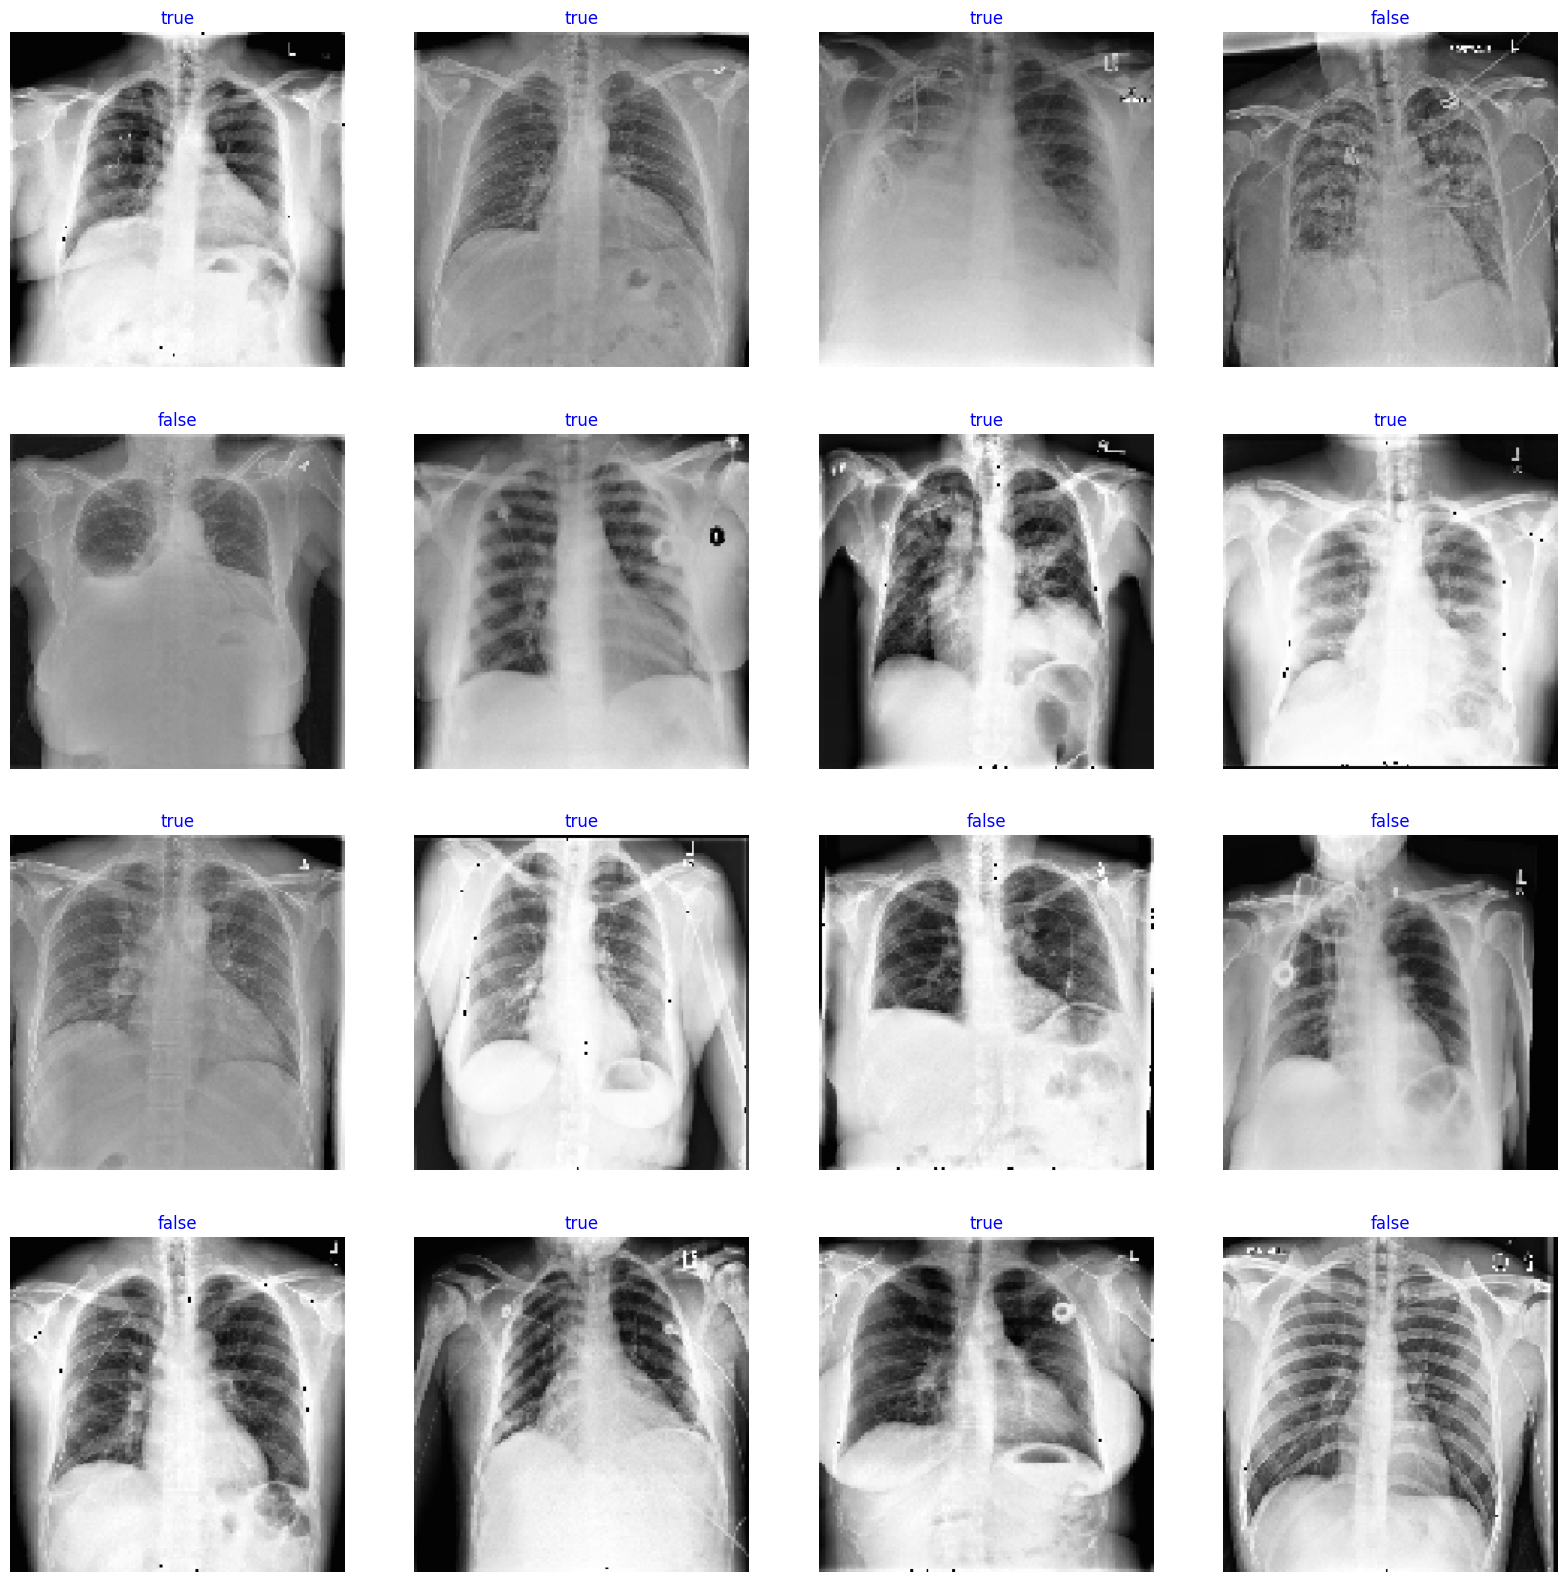

In [9]:
gen_dict = train_gen.class_indices      # {'false':0, 'true':1}
classes = list(gen_dict.keys())        # ['false', 'true']

images, labels = next(train_gen)       # get one batch from the generator

plt.figure(figsize=(20,20))
for i in range(16):                    # show first 16 images in that batch
    plt.subplot(4,4,i+1)
    image = images[i] / 255            # scale pixel values (0–255 → 0–1)
    plt.imshow(image)
    index = np.argmax(labels[i])       # convert one-hot label to class index
    class_name = classes[index]        # map index back to 'true' or 'false'
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()


## **Model Training**

In [10]:
# Get class names from the generator
gen_dict = train_gen.class_indices      # e.g. {'false': 0, 'true': 1}
classes = list(gen_dict.keys())
num_class = len(classes)

# Input shape for EfficientNetB0
img_shape = (img_size[0], img_size[1], 3)

# Base model: EfficientNetB0 (pretrained on ImageNet)
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'     # global max pooling on feature maps
)

# Freeze the base model (only train the new top layers first)
base_model.trainable = False

# Add custom classification head
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(num_class, activation='softmax')  # 2 classes: true/false
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,141 (16.72 MB)

 Trainable params: 331,010 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [11]:
Epochs = 10

history = model.fit(
    x=train_gen,
    epochs=Epochs,
    verbose=1,
    validation_data=valid_gen,
    shuffle=False
)


Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.5577 - loss: 0.9174 - val_accuracy: 0.6374 - val_loss: 0.7029
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.6412 - loss: 0.7016 - val_accuracy: 0.6363 - val_loss: 0.6785
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.7044 - loss: 0.6092 - val_accuracy: 0.6441 - val_loss: 0.6644
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.7072 - loss: 0.5674 - val_accuracy: 0.6633 - val_loss: 0.6475
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 293s 1s/step - accuracy: 0.7576 - loss: 0.5026 - val_accuracy: 0.6678 - val_loss: 0.6313
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 306s 1s/step - accuracy: 0.7759 - loss: 0.4657 - val_accuracy: 0.6712 - val_loss: 0.6474
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.7970 - loss: 0.4412 - val_accuracy: 0.6745 - val_loss: 0.6548
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.8083 - loss: 0.4130 - val_accu

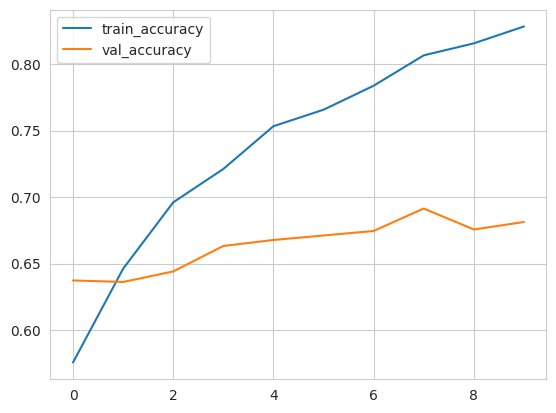

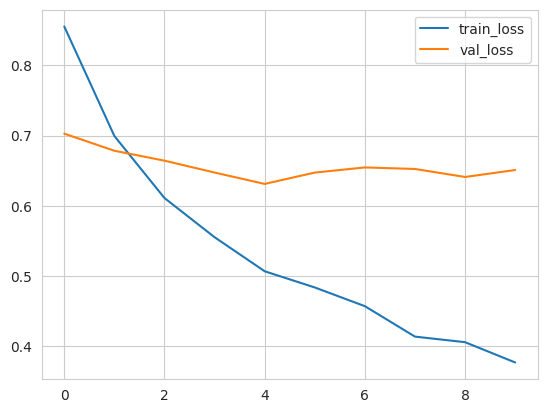

In [12]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


In [13]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test accuracy:", test_acc)


70/70 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6850 - loss: 0.6366
Test accuracy: 0.666965901851654


In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = test_df['label'].map({'false':0, 'true':1}).values
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


70/70 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step
              precision    recall  f1-score   support

           0       0.66      0.69      0.67       557
           1       0.67      0.65      0.66       557

    accuracy                           0.67      1114
   macro avg       0.67      0.67      0.67      1114
weighted avg       0.67      0.67      0.67      1114

[[383 174]
 [197 360]]


In [15]:
model.save('cardio_model_effnetB0.h5')
